# Logistic Regression (Coffees dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [2]:
# import local utility functions
import sys
sys.path.append('../utils')
import utils as utl

## Load raw data and plot

In [3]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/coffees/FTIR_instant_coffees.csv')
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
1,10.364243,10.569554,10.448875,10.100696,9.620371,8.882499,8.415529,8.210217,7.916430,7.806151,...,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705,1,Arabica
2,13.118324,13.507084,13.473495,12.871428,12.181919,11.239480,10.515672,10.468178,10.428742,10.212771,...,2.236715,2.214229,2.196218,2.181646,2.164602,2.146423,2.133255,2.121559,1,Arabica
3,15.668409,15.803868,15.977607,15.569489,14.950423,14.029599,13.396739,13.092360,12.784991,12.829988,...,3.020125,2.987411,2.963816,2.954810,2.942520,2.909018,2.880989,2.876201,1,Arabica
4,16.634960,17.055263,17.610495,17.211594,16.217897,15.287751,14.424133,13.928921,13.551499,13.288979,...,3.310964,3.281866,3.263161,3.241584,3.213549,3.183820,3.157357,3.146584,1,Arabica


In [4]:
# shuffle data rows
data = data.sample(frac=1)

Arabica: blue
Robusta: red


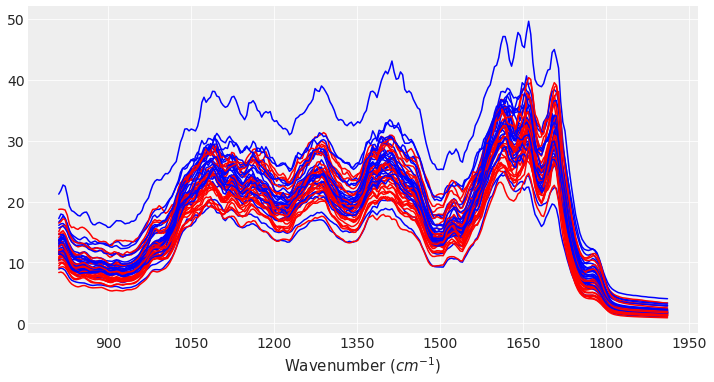

In [6]:
# name of column containing the labels
label_col = 'label'

# number of non-data columns at right of dataframe
non_data_cols = -2

# list of class labels
class_labels = utl.get_class_labels(data, label_col)

# plot dataframe
utl.plot_data(data, non_data_cols, label_col, 50)

In [7]:
# number of samples from each class
data[label_col].value_counts()

Arabica    29
Robusta    27
Name: label, dtype: int64

In [8]:
# generate training and test sets
train_data, test_data = train_test_split(data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [9]:
test_data.shape

(19, 288)

In [10]:
train_data.shape

(37, 288)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = logistic(\alpha+\beta X) \\
y \sim Bernoulli(\theta)
\end{equation}

In [11]:
# get Y labels and standardize the data
Y = pd.Categorical(train_data[label_col]).codes
x_n = train_data.columns[:non_data_cols]
x_s = train_data[x_n].values
x_s = utl.standardize(x_s)

In [11]:
with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 

    trace_mlr = pm.sample(2000, init='adapt_diag', random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [34:15<00:00,  2.43draws/s] 
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


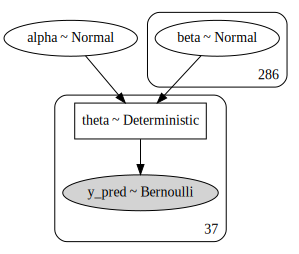

In [12]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [13]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.693,6.720,-12.994,11.983,0.131,0.111,2618.0,1821.0,2617.0,2374.0,1.0
beta[0],-0.080,9.652,-18.742,17.830,0.164,0.167,3474.0,1672.0,3471.0,2315.0,1.0
beta[1],-0.033,9.707,-17.865,17.794,0.153,0.160,4048.0,1847.0,4054.0,2654.0,1.0
beta[2],0.324,9.708,-18.945,17.573,0.156,0.160,3867.0,1837.0,3867.0,2649.0,1.0
beta[3],0.973,9.956,-18.194,19.678,0.152,0.185,4270.0,1454.0,4274.0,2249.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[281],-1.219,9.664,-19.425,16.358,0.152,0.164,4037.0,1742.0,4042.0,2627.0,1.0
beta[282],-1.421,9.867,-19.645,16.995,0.154,0.166,4116.0,1774.0,4129.0,2647.0,1.0
beta[283],-1.301,10.166,-19.923,18.013,0.166,0.186,3760.0,1497.0,3753.0,2426.0,1.0
beta[284],-1.311,9.916,-19.402,16.949,0.161,0.183,3776.0,1461.0,3749.0,2320.0,1.0


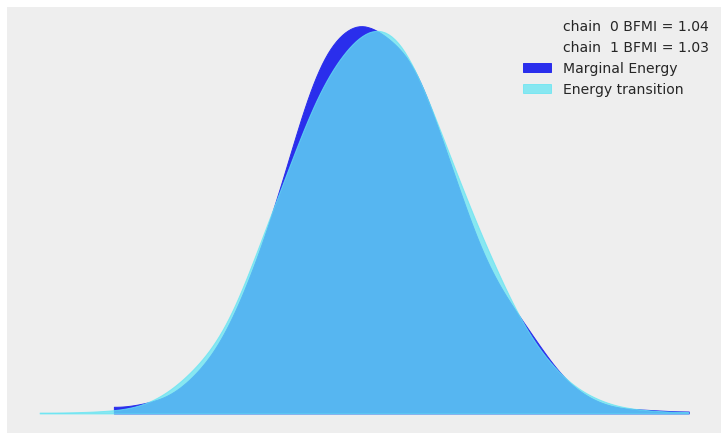

In [14]:
az.plot_energy(trace_mlr, figsize=(10, 6));

In [15]:
# check model predictions on test dataset
utl.display_predictions(trace_mlr, test_data, non_data_cols, class_labels)

    code    label  pred pred_label
0      2  Robusta   1.0    Robusta
1      2  Robusta   1.0    Robusta
2      2  Robusta   1.0    Robusta
3      1  Arabica   0.0    Arabica
4      2  Robusta   1.0    Robusta
5      1  Arabica   0.0    Arabica
6      2  Robusta   1.0    Robusta
7      2  Robusta   1.0    Robusta
8      2  Robusta   1.0    Robusta
9      1  Arabica   0.0    Arabica
10     1  Arabica   0.0    Arabica
11     1  Arabica   0.0    Arabica
12     2  Robusta   1.0    Robusta
13     2  Robusta   1.0    Robusta
14     1  Arabica   0.0    Arabica
15     1  Arabica   0.0    Arabica
16     1  Arabica   0.0    Arabica
17     1  Arabica   0.0    Arabica
18     1  Arabica   0.0    Arabica


In [21]:
# prediction score on test dataset
utl.logistic_score(test_data, label_col, test_data.iloc[:,-1])

total  : 19
correct: 19
error  : 0
score  : 100.0%


# Save inference results

In [22]:
pm.backends.text.dump('./traces/trace_coffees', trace_mlr)